<h1>Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Training,-validation,-test-sets" data-toc-modified-id="Training,-validation,-test-sets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training, validation, test sets</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>TF-IDF</a></span></li><li><span><a href="#Target-feature-analysis" data-toc-modified-id="Target-feature-analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Target feature analysis</a></span><ul class="toc-item"><li><span><a href="#Changing-class-weights" data-toc-modified-id="Changing-class-weights-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Changing class weights</a></span></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Downsampling</a></span></li></ul></li><li><span><a href="#Comparative-analysis" data-toc-modified-id="Comparative-analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Comparative analysis</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model training</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>SGDClassifier</a></span></li></ul></li><li><span><a href="#Model-Analysis" data-toc-modified-id="Model-Analysis-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Model Analysis</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#General-conclusions" data-toc-modified-id="General-conclusions-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>General conclusions</a></span></li></ul></div>

# Definition of toxicity of English-language comments

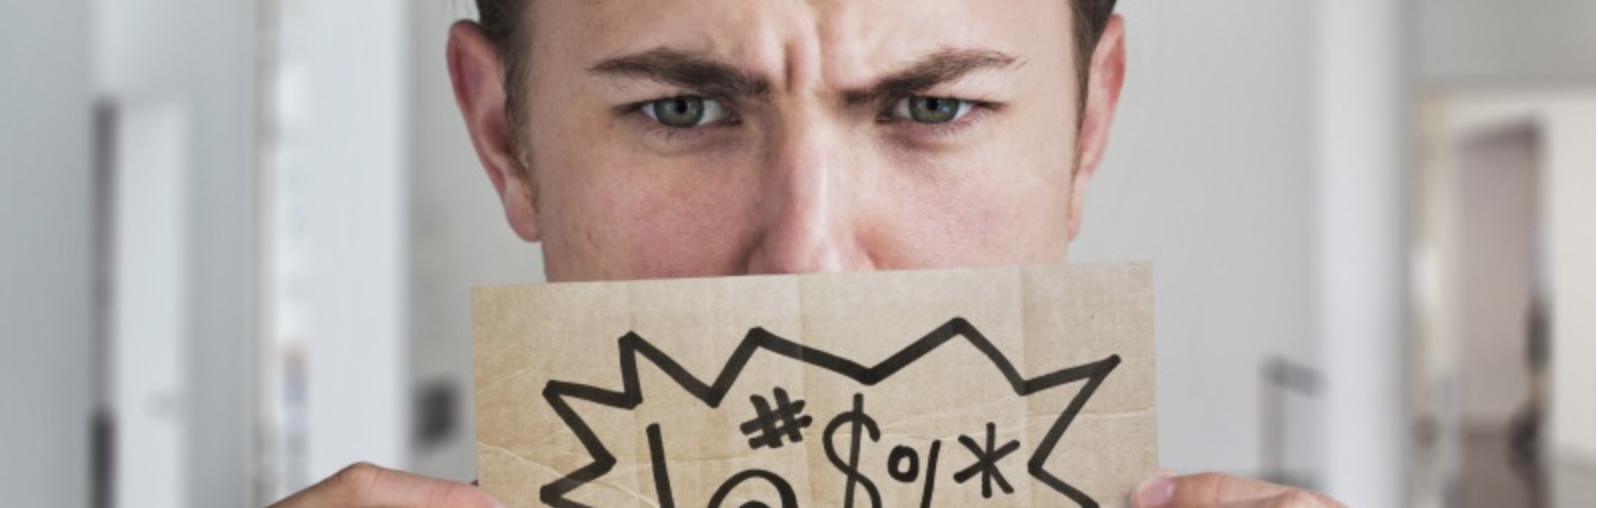

The online store launches a new service. Now users can edit and supplement product descriptions. That is, clients propose their edits and comment on the changes of others. The store needs a tool that will look for toxic comments and submit them for moderation.

It is necessary to train the model to classify comments into positive and negative. We have a data set with markup on the toxicity of edits. It is necessary to build a model with the value of the quality metric F1 not less than 0.75.

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [3]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
pd.set_option('display.max_colwidth', 1000)

In [5]:
toxic_comments.head(10)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


**The text column contains the text of the comment, and toxic is the target attribute. If the post is positive, then mark 0, if negative - 1.**

In [6]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


## Data preprocessing

Before extracting features from the text, let's simplify it. For this:

- Change all uppercase values to lowercase;
- We reduce the words to the initial form (lemma);
- Combine the elements of the list by separating them with spaces;
- Let's leave only Latin characters in the text;
- Remove extra spaces;

In [7]:
m = Mystem()
def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(m.lemmatize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())
toxic_comments['lemm_text'] = toxic_comments['text'].apply(lemmatize_text)
toxic_comments = toxic_comments.drop(['text'], axis=1)

In [8]:
toxic_comments.head()

,toxic,lemm_text
0,0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now
1,0,d aww he matches this background colour i m seemingly stuck with thanks talk january utc
2,0,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info
3,0,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good article nominationstransport
4,0,you sir are my hero any chance you remember what page that s on


## Training, validation, test sets

Divide the original dataset into training, validation and test sets in a ratio of 3:1:1

In [9]:
target = toxic_comments['toxic']
features = toxic_comments.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=12345)

## TF-IDF

Let's create matrices with TF-IDF values for our samples (tweet corpuses), for this we will create a counter, specifying stop words in it. For corpora, let's convert the text to Python's standard Unicode format.

In [10]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords);

features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values.astype('U'))
features_valid = count_tf_idf.transform(features_valid['lemm_text'].values.astype('U'))
features_test = count_tf_idf.transform(features_test['lemm_text'].values.astype('U'))
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(95742, 126482)
(31914, 126482)
(31915, 126482)


## Target feature analysis

Determine the number of negative comments.

In [11]:
toxic_comments['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

In [12]:
classificator = LogisticRegression()
train_f1 = cross_val_score(classificator, features_train, target_train, cv=3, scoring='f1').mean()
print('F1 на CV', train_f1)

F1 на CV 0.6732751694870752


To solve the classification problem, such a difference in classes negatively affects the future model due to a strong imbalance. The model will be retrained because the machine learning algorithms consider all objects in the training set to be equivalent by default. Align the frequency indicator using the downsampling technique and changing the weights of the classes.

### Changing class weights

Let's change the class weights using the built-in balancing method.

In [13]:
classificator = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, features_train, target_train, cv=3, scoring='f1').mean()
print('F1 on CV with class balancing', train_f1_balanced)

F1 on CV with class balancing 0.7444308965221991


As can be seen from the cross-validation, changing the balance of classes has a positive effect on the F1 score.

### Downsampling

In [14]:
toxic_comments_train = toxic_comments.iloc[target_train.index]
target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

In [15]:
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12345)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = toxic_comments.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12345)
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text']
                                                   .values.astype('U'))

In [16]:
classificator = LogisticRegression()
train_f1_downsampled = cross_val_score(classificator,
                      features_train_downsample, 
                      target_train_downsample, 
                      cv=3, 
                      scoring='f1').mean()
print('F1 on CV with decreasing classes', train_f1_downsampled)

F1 on CV with decreasing classes 0.8792825300830076


The value of the F1 metric also increased significantly.

## Comparative analysis

Let's compare the indicator of the F1 metric for the initial and prepared data on the validation set.

In [19]:
classificator = LogisticRegression()
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
valid_f1 = f1_score(target_valid, classificator.predict(features_valid))

classificator = LogisticRegression(class_weight = 'balanced')
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
valid_f1_balanced = f1_score(target_valid, classificator.predict(features_valid))

classificator = LogisticRegression()
classificator.fit(features_train_downsample,target_train_downsample)
probabilities_valid = classificator.predict_proba(features_valid)
valid_f1_downsampled = f1_score(target_valid, classificator.predict(features_valid))

index = ['LogisticRegression',
         'LogisticRegression (balansed classes)',
         'LogisticRegression (downsampled classes)']
data = {'F1 on validation':[valid_f1, valid_f1_balanced, valid_f1_downsampled]}
scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 on validation
LogisticRegression,0.727239
LogisticRegression (balansed classes),0.753950
LogisticRegression (downsampled classes),0.695566


### Conclusion
1. Data processed and prepared.
2. A comparative analysis of methods for balancing the target trait was carried out.
3. For further use, in order to build models, the method of changing the class weights is chosen.
4. The result on the validation set is 0.753

## Model training

### LogisticRegression

In [24]:
classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':['balanced']}]

clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=3)
clf.fit(features_train, target_train)
LR_best_params = clf.best_params_
print(LR_best_params)

{'C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}


In [25]:
classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 on validation', valid_f1_LR)

F1 on validation 0.7676354607857456


### DecisionTreeClassifier

In [30]:
classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(10,100,10)],
                'random_state':[12345],
                'class_weight':['balanced']}]

clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=3)
clf.fit(features_train, target_train)
DTC_best_params = clf.best_params_
print(DTC_best_params)

{'class_weight': 'balanced', 'max_depth': 90, 'random_state': 12345}


In [31]:
classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 on validation', valid_f1_DTC)

F1 on validation 0.6364423909904707


### SGDClassifier

Stochastic Gradient Descent

In [32]:
classificator = SGDClassifier()
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[12345],
                'class_weight':['balanced']}]

clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=3)
clf.fit(features_train, target_train)
SGDC_best_params = clf.best_params_
print(SGDC_best_params)

{'class_weight': 'balanced', 'eta0': 0.2, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 12345}


In [33]:
classificator = SGDClassifier()
classificator.set_params(**SGDC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_SGDC = f1_score(target_valid, target_predict)
print('F1 on validation', valid_f1_SGDC)

F1 on validation 0.7624187076241872


## Model Analysis

In [34]:
index = ['LogisticRegression', 'DecisionTreeClassifier', 'SGDClassifier']
data = {'F1 on validation':[valid_f1_LR, valid_f1_DTC, valid_f1_SGDC]}
scores_data = pd.DataFrame(data=data, index=index)
scores_data['F1 > 0.75'] = scores_data['F1 on validation'] > 0.75
scores_data

,F1 on validation,F1 > 0.75
LogisticRegression,0.767635,True
DecisionTreeClassifier,0.636442,False
SGDClassifier,0.762419,True


To solve the problem, from the constructed models, the following are suitable:

1. **LogisticRegression**
2. **SGDClassifier**

## Test

In [35]:
classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
predict_test = classificator.predict(features_test)
print('F1 на LogisticRegression:', f1_score(target_test, predict_test))

classificator = SGDClassifier()
classificator.set_params(**SGDC_best_params)
classificator.fit(features_train, target_train)
predict_test = classificator.predict(features_test)
print('F1 на SGDClassifier:', f1_score(target_test, predict_test))

F1 на LogisticRegression: 0.7697300486797463
F1 на SGDClassifier: 0.7545644599303136


## General conclusions
The customer's condition is to build a model to determine toxic comments, with the value of the quality metric F1 not less than 0.75. This condition was met

For further work, I suggest using the LogisticRegression model with optimal parameters ('C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}). The value of F1 obtained on the test sample is 0.77